# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
from pathlib import Path

PCAP_PATH = Path("/Users/virajbodiwala/Downloads/netflix.pcap")
assert PCAP_PATH.exists(), f"PCAP not found at: {PCAP_PATH}"

print("Using pcap:", PCAP_PATH)

Using pcap: /Users/virajbodiwala/Downloads/netflix.pcap


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [2]:
import nest_asyncio, asyncio
nest_asyncio.apply()

import pyshark
from collections import defaultdict

# Pass 1: read all IP packets and total bytes sent per source IP
cap_all = pyshark.FileCapture(
    str(PCAP_PATH),
    display_filter="ip",
    only_summaries=False,
    keep_packets=False,
    use_json=True,
)

bytes_src_to_dst = defaultdict(int)

for pkt in cap_all:
    try:
        if not hasattr(pkt, 'ip'):
            continue
        src = pkt.ip.src
        length = int(pkt.length)
        bytes_src_to_dst[src] += length
    except Exception:
        continue

cap_all.close()

# Sort by who sent us the most data
top_senders = sorted(bytes_src_to_dst.items(), key=lambda x: x[1], reverse=True)
print("Top senders by total bytes:", top_senders[:10])

# Based on inspection, we saw that the heavy hitters were in 198.38.120.x
netflix_ips = {
    '198.38.120.166',
    '198.38.120.164',
    '198.38.120.162',
    '198.38.120.137',
    '198.38.120.134',
}
print("Inferred Netflix CDN IPs:", netflix_ips)

Top senders by total bytes: [('198.38.120.166', 120607242), ('198.38.120.164', 7138148), ('192.168.43.72', 4184927), ('23.57.80.120', 1332086), ('198.38.120.162', 431178), ('52.19.39.146', 348141), ('198.38.120.137', 116255), ('172.217.18.195', 98271), ('198.38.120.134', 90447), ('216.58.209.228', 71268)]
Inferred Netflix CDN IPs: {'198.38.120.134', '198.38.120.137', '198.38.120.164', '198.38.120.166', '198.38.120.162'}


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [ ]:
import nest_asyncio, asyncio
nest_asyncio.apply()

import pyshark
import numpy as np
import pandas as pd
from collections import defaultdict

WINDOW = 1.0
flow_buckets = defaultdict(lambda: defaultdict(list))

cap2 = pyshark.FileCapture(
    str(PCAP_PATH),
    display_filter="ip",
    only_summaries=False,
    keep_packets=False,
    use_json=True
)

def get_flow_key(pkt):
    ip = pkt.ip
    proto = pkt.transport_layer or 'OTHER'

    if proto == 'TCP' and hasattr(pkt, 'tcp'):
        sport = pkt.tcp.srcport
        dport = pkt.tcp.dstport
    elif proto == 'UDP' and hasattr(pkt, 'udp'):
        sport = pkt.udp.srcport
        dport = pkt.udp.dstport
    else:
        sport = '0'
        dport = '0'

    return (ip.src, sport, ip.dst, dport, proto)

for pkt in cap2:
    try:
        if not hasattr(pkt, 'ip') or pkt.ip is None:
            continue

        src_ip = pkt.ip.src
        dst_ip = pkt.ip.dst

        if (src_ip not in netflix_ips) and (dst_ip not in netflix_ips):
            continue

        ts = float(pkt.sniff_timestamp)
        bucket = int(ts // WINDOW)

        length = int(pkt.length)
        proto = pkt.transport_layer or 'OTHER'

        direction = "down" if src_ip in netflix_ips else "up"

        flow_key = get_flow_key(pkt)

        flow_buckets[flow_key][bucket].append({
            "ts": ts,
            "len": length,
            "dir": direction,
            "proto": proto,
        })

    except Exception:
        continue

cap2.close()

rows = []
for flow_key, buckets in flow_buckets.items():
    src, sport, dst, dport, proto = flow_key
    for bucket, pkts in buckets.items():
        ts_list = [p["ts"] for p in pkts]
        lens = [p["len"] for p in pkts]

        down_bytes = sum(p["len"] for p in pkts if p["dir"] == "down")
        up_bytes   = sum(p["len"] for p in pkts if p["dir"] == "up")
        down_pkts  = sum(1 for p in pkts if p["dir"] == "down")
        up_pkts    = sum(1 for p in pkts if p["dir"] == "up")

        ts_sorted = sorted(ts_list)
        if len(ts_sorted) > 1:
            iats = np.diff(ts_sorted)
            mean_iat = float(np.mean(iats))
            std_iat  = float(np.std(iats))
        else:
            mean_iat = np.nan
            std_iat  = np.nan

        rows.append({
            "bucket_time_start": bucket * WINDOW,
            "src_ip": src,
            "src_port": sport,
            "dst_ip": dst,
            "dst_port": dport,
            "proto": proto,

            "down_bytes": down_bytes,
            "up_bytes": up_bytes,
            "down_pkts": down_pkts,
            "up_pkts": up_pkts,

            "total_bytes": down_bytes + up_bytes,
            "total_pkts": down_pkts + up_pkts,

            "mean_pkt_size": float(np.mean(lens)),
            "std_pkt_size": float(np.std(lens)),

            "mean_iat": mean_iat,
            "std_iat": std_iat,

            "throughput_bps": (down_bytes * 8.0) / WINDOW,
        })

features_df = pd.DataFrame(rows)
features_df.sort_values("bucket_time_start").head()

,bucket_time_start,src_ip,src_port,dst_ip,dst_port,proto,down_bytes,up_bytes,down_pkts,up_pkts,total_bytes,total_pkts,mean_pkt_size,std_pkt_size,mean_iat,std_iat,throughput_bps
0,1.518358e+09,192.168.43.72,58481,198.38.120.137,443,TCP,0,78,0,1,78,1,78.0,0.0,NaN,NaN,0.0
18,1.518358e+09,192.168.43.72,58493,198.38.120.137,443,TCP,0,78,0,1,78,1,78.0,0.0,NaN,NaN,0.0
11,1.518358e+09,192.168.43.72,58482,198.38.120.137,443,TCP,0,78,0,1,78,1,78.0,0.0,NaN,NaN,0.0
12,1.518358e+09,192.168.43.72,58482,198.38.120.137,443,TCP,0,78,0,1,78,1,78.0,0.0,NaN,NaN,0.0
19,1.518358e+09,192.168.43.72,58493,198.38.120.137,443,TCP,0,78,0,1,78,1,78.0,0.0,NaN,NaN,0.0


**Write a brief justification for the features that you have chosen.**

For each 1-second window of Netflix traffic, I compute a set of per-flow statistics that describe how the video is being delivered on the network. These features are useful because adaptive video quality (the resolution you actually see) depends on how fast and how smoothly the video data arrives, not on the decrypted video content.
down_bytes / up_bytes / throughput_bps
down_bytes is the number of bytes sent from the server (Netflix CDN) to the client in that window. up_bytes is how many bytes the client sent to the server (mostly requests and ACKs). From down_bytes we also compute throughput_bps, which is the downstream throughput in bits per second. Higher resolutions (720p, 1080p) require higher sustained throughput. When throughput drops, adaptive bitrate algorithms lower resolution. So these features are directly tied to the quality level the player can sustain.
down_pkts / up_pkts / total_pkts / total_bytes
These capture how active the flow is. Video data tends to arrive in bursts of packets from the CDN to the client. A 1080p stream will usually move more data per second and in larger bursts than a 240p stream. Sudden drops in downstream packet/byte rate across windows can indicate stalls or buffering events.
mean_pkt_size / std_pkt_size
These summarize the packet size distribution in that window. Large, consistent packet sizes usually mean we’re transferring video segment payload data (bulk encrypted video chunks). Lots of very small packets or very high variability looks more like control/overhead traffic. This helps differentiate “actual segment download” vs. “just talking to the service.”
mean_iat / std_iat
These are the mean and standard deviation of inter-arrival times between packets in the window. Streaming video players typically download a segment as a tight burst (very low inter-arrival time, packets back-to-back), then pause until the next segment. If the connection is struggling, those bursts become less regular, or the gaps get longer. So timing smoothness is related to whether playback is healthy at a given resolution.
bucket_time_start
This is the start time of the 1-second bucket. We use it to align windows over time and later merge per-window data, but we don’t use it as a predictive feature. It’s just the time anchor for each row.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [4]:
import numpy as np
import pandas as pd

# 1. Collect all downstream packet timestamps from the parsed pcap traffic

down_ts_list = []

for flow_key, buckets in flow_buckets.items():
    for bucket_idx, pkts in buckets.items():
        for p in pkts:
            if p["dir"] == "down":
                down_ts_list.append(p["ts"])

down_ts = np.array(sorted(down_ts_list), dtype=float)

print("Total downstream packets observed:", len(down_ts))
print("First few downstream packet timestamps:", down_ts[:10])


# 2. Detect segment "bursts"

BURST_GAP_SECONDS = 1.0

if len(down_ts) == 0:
    burst_start_ts = np.array([], dtype=float)
else:
    gaps = np.diff(down_ts, prepend=down_ts[0])
    burst_start_mask = (gaps >= BURST_GAP_SECONDS)
    burst_start_mask[0] = True
    burst_start_ts = down_ts[burst_start_mask]

print("Total inferred bursts (segments):", len(burst_start_ts))
print("First few burst start times:", burst_start_ts[:10])

# 3. Count how many bursts START in each 1-second window

WINDOW = 1.0

if len(burst_start_ts) > 0:
    burst_bucket_times = (burst_start_ts // WINDOW) * WINDOW
    burst_bucket_times = burst_bucket_times.astype(float)
    burst_counts = (
        pd.Series(burst_bucket_times)
        .value_counts()
        .rename_axis("bucket_time_start")
        .reset_index(name="segment_downloads_rate")
        .sort_values("bucket_time_start")
    )
else:
    burst_counts = pd.DataFrame(columns=["bucket_time_start", "segment_downloads_rate"])

print("Burst counts (head):")
print(burst_counts.head())

# 4. Aggregate flow-level stats into per-window stats (1 row per second),

window_df = (
    features_df
    .groupby("bucket_time_start")
    .agg({
        "throughput_bps": "sum",
        "down_bytes": "sum",
        "total_bytes": "sum",
        "total_pkts": "sum",
        "down_pkts": "sum",
        "mean_iat": "mean",
        "std_iat": "mean",
        "mean_pkt_size": "mean",
        "std_pkt_size": "mean"
    })
    .reset_index()
    .sort_values("bucket_time_start")
)

window_df = window_df.merge(
    burst_counts,
    on="bucket_time_start",
    how="left"
)

window_df["segment_downloads_rate"] = window_df["segment_downloads_rate"].fillna(0).astype(int)

print("Final per-second features with segment_downloads_rate:")
window_df.head()

Total downstream packets observed: 85465
First few downstream packet timestamps: [1.51835821e+09 1.51835821e+09 1.51835821e+09 1.51835821e+09
 1.51835821e+09 1.51835821e+09 1.51835821e+09 1.51835821e+09
 1.51835821e+09 1.51835821e+09]
Total inferred bursts (segments): 74
First few burst start times: [1.51835821e+09 1.51835821e+09 1.51835822e+09 1.51835830e+09
 1.51835830e+09 1.51835830e+09 1.51835831e+09 1.51835831e+09
 1.51835832e+09 1.51835833e+09]
Burst counts (head):
    bucket_time_start  segment_downloads_rate
0        1.518358e+09                       1
19       1.518358e+09                       1
54       1.518358e+09                       1
53       1.518358e+09                       1
52       1.518358e+09                       1
Final per-second features with segment_downloads_rate:


,bucket_time_start,throughput_bps,down_bytes,total_bytes,total_pkts,down_pkts,mean_iat,std_iat,mean_pkt_size,std_pkt_size,segment_downloads_rate
0,1.518358e+09,0.0,0,234,3,0,NaN,NaN,78.000000,0.000000,0
1,1.518358e+09,0.0,0,234,3,0,NaN,NaN,78.000000,0.000000,0
2,1.518358e+09,1184.0,148,1070,9,2,0.091556,0.090902,101.466667,38.893130,1
3,1.518358e+09,592.0,74,140,2,1,NaN,NaN,70.000000,0.000000,0
4,1.518358e+09,4016.0,502,832,12,7,0.480434,0.149260,69.111111,1.257079,0


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [5]:
import pickle
import pandas as pd
from pathlib import Path

DATA_PATH = Path("/Users/virajbodiwala/Downloads/netflix_dataset.pkl")
assert DATA_PATH.exists(), f"Could not find file at {DATA_PATH}"

with open(DATA_PATH, "rb") as f:
    obj = pickle.load(f)

if isinstance(obj, dict):
    print("top-level type: dict")
    print("keys:", list(obj.keys())[:30])
    netflix_df = pd.DataFrame(obj)
else:
    print("top-level type:", type(obj))
    netflix_df = obj

print("shape:", getattr(netflix_df, "shape", None))

cols = list(netflix_df.columns)
print("num cols:", len(cols))
print("first 20 cols:", cols[:20])

preview_cols = cols[:10]
display(netflix_df[preview_cols].head())

netflix_df.info(max_cols=40, memory_usage='deep')

top-level type: <class 'pandas.core.frame.DataFrame'>
shape: (52279, 251)
num cols: 251
first 20 cols: ['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev']


,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0


<class 'pandas.core.frame.DataFrame'>
Index: 52279 entries, 208 to 200638
Columns: 251 entries, 10_EWMA_chunksizes to startup_mc
dtypes: bool(6), float64(166), int64(72), object(7)
memory usage: 124.9 MB


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [6]:
import re
import pandas as pd

VALID_RESOLUTIONS = {240, 360, 480, 720, 1080}

def normalize_resolution(val):
    """
    Convert raw resolution into one of {240,360,480,720,1080}.

    Handles:
    - "720p" -> 720
    - "1080" -> 1080
    - "1280x720" or "1920 x 1080" -> 720 / 1080
    - numeric 480 -> 480
    Returns None if it can't map.
    """
    if pd.isna(val):
        return None

    s = str(val).lower().strip()

    s_plain = s.replace("p", "")
    try:
        num_plain = int(s_plain)
        if num_plain in VALID_RESOLUTIONS:
            return num_plain
    except ValueError:
        pass

    nums = re.findall(r"\d+", s)
    candidates = [int(n) for n in nums if int(n) in VALID_RESOLUTIONS]
    if len(candidates) > 0:
        return max(candidates)

    return None

netflix_df["resolution_norm"] = netflix_df["resolution"].apply(normalize_resolution)

clean_df = netflix_df.dropna(subset=["resolution_norm"]).copy()
clean_df["resolution_norm"] = clean_df["resolution_norm"].astype(int)

print("Original rows:", len(netflix_df))
print("Rows after filtering to valid resolutions:", len(clean_df))
print("Resolution distribution after cleaning:")
print(clean_df["resolution_norm"].value_counts())

sample_check = netflix_df[["resolution"]].copy()
sample_check["resolution_norm"] = netflix_df["resolution"].apply(normalize_resolution)
sample_check.head(20)

Original rows: 52279
Rows after filtering to valid resolutions: 49748
Resolution distribution after cleaning:
resolution_norm
480     29486
720      9457
1080     4628
360      4476
240      1701
Name: count, dtype: int64


,resolution,resolution_norm
208,360.0,360.0
209,360.0,360.0
210,360.0,360.0
211,360.0,360.0
212,480.0,480.0
213,480.0,480.0
214,480.0,480.0
215,480.0,480.0
216,480.0,480.0
217,480.0,480.0


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [7]:
df = clean_df.copy()

possible_split_cols = [
    c for c in df.columns 
    if c.lower() in ("split", "set", "partition", "train_test_split", "subset", "phase")
]
print("Possible split columns:", possible_split_cols)

Possible split columns: []


**Briefly explain why you removed those columns.**

We removed certain columns from the dataset before training the model because they would either leak the answer directly or cause the model to “cheat” in a way that wouldn’t generalize.
First, we removed the resolution labels themselves (resolution, resolution_norm) from the feature matrix. Those columns are what we’re trying to predict, so leaving them in the input features would let the model trivially learn a direct mapping instead of actually inferring video quality from network behavior.
Second, we removed identifiers and session-specific metadata such as IP addresses (client_ip, server_ip, src_ip, dst_ip), timestamps (absolute_timestamp, time_start, time_end), and IDs like session_id or trace_id. These fields describe who we were connected to and exactly when the capture occurred. If we included them, the model could just memorize that “session X at time Y was 1080p,” which works on this dataset but completely fails on a new session. That’s overfitting, not learning.
Finally, we kept only numeric, traffic-derived measurements (e.g. throughput, bytes downloaded per second, packet timing statistics, segment download rate). These features reflect the actual delivery behavior of the video stream: how fast content is arriving, how bursty the transfer is, and how often new segments are fetched. Those are the signals an adaptive video player actually uses internally to select a resolution.


The dataset did not include a built-in column that marks which rows belong to training and which rows belong to testing (for example, a column called split, set, or partition). Because possible_split_cols came up empty, we created our own train/test split using train_test_split with stratification on the resolution label. Stratification keeps the class balance (240p, 360p, 480p, 720p, 1080p) similar in both splits, so the model is evaluated on a test set that reflects the same variety of quality levels as the training set. This approach is acceptable when a dataset doesn’t ship with an explicit split.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = clean_df.copy()

cols_to_always_drop = [
    "resolution",
    "resolution_norm",
    "client_ip", "server_ip", "src_ip", "dst_ip",
    "session_id", "trace_id", "flow_id",
    "timestamp_start", "timestamp_end",
    "time_start", "time_end",
    "bucket_time_start",
    "t", "time", "ts", "unix_ts",
    "absolute_timestamp",
]

y = df["resolution_norm"].astype(int)

X_full = df.copy()

for c in cols_to_always_drop:
    if c in X_full.columns:
        del X_full[c]

X_full = X_full.select_dtypes(include=["number"])

if "resolution_norm" in X_full.columns:
    X_full = X_full.drop(columns=["resolution_norm"])

print("X_full shape:", X_full.shape)
print("y shape:", y.shape)
print("Sample feature columns:", list(X_full.columns)[:15])

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train distribution:\n", y_train.value_counts(normalize=True).rename("proportion"))
print("Test distribution:\n", y_test.value_counts(normalize=True).rename("proportion"))


X_full shape: (49748, 236)
y shape: (49748,)
Sample feature columns: ['10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'access_50_perc', 'access_75_perc', 'access_avg']
Train size: (39798, 236) Test size: (9950, 236)
Train distribution:
 resolution_norm
480     0.592718
720     0.190085
1080    0.093020
360     0.089979
240     0.034198
Name: proportion, dtype: float64
Test distribution:
 resolution_norm
480     0.592663
720     0.190151
1080    0.093065
360     0.089950
240     0.034171
Name: proportion, dtype: float64


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("Trained baseline RandomForest.")

Trained baseline RandomForest.


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [ ]:
best_model = rf

print("Using baseline RandomForest as best_model.")
print("Params we used:")
print(" n_estimators       =", rf.n_estimators)
print(" max_depth          =", rf.max_depth)
print(" min_samples_split  =", rf.min_samples_split)

Using baseline RandomForest as best_model.
Params we used:
 n_estimators       = 200
 max_depth          = None
 min_samples_split  = 2


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [11]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

model = best_model

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Macro F1 Score:", f1_macro)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

classes_sorted = np.sort(y.unique())
y_test_bin = label_binarize(y_test, classes=classes_sorted)
y_prob = model.predict_proba(X_test)

auc_macro = roc_auc_score(
    y_test_bin,
    y_prob,
    average="macro",
    multi_class="ovr"
)
print("Macro ROC/AUC:", auc_macro)

Accuracy: 0.9517587939698492
Macro F1 Score: 0.8957518506202724

Confusion Matrix:
 [[ 206   41   76   17    0]
 [  24  761   99   11    0]
 [  18   27 5812   38    2]
 [   5    1   90 1773   23]
 [   0    0    1    7  918]]

Classification Report:
               precision    recall  f1-score   support

         240       0.81      0.61      0.69       340
         360       0.92      0.85      0.88       895
         480       0.96      0.99      0.97      5897
         720       0.96      0.94      0.95      1892
        1080       0.97      0.99      0.98       926

    accuracy                           0.95      9950
   macro avg       0.92      0.87      0.90      9950
weighted avg       0.95      0.95      0.95      9950

Macro ROC/AUC: 0.9949158490165161


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

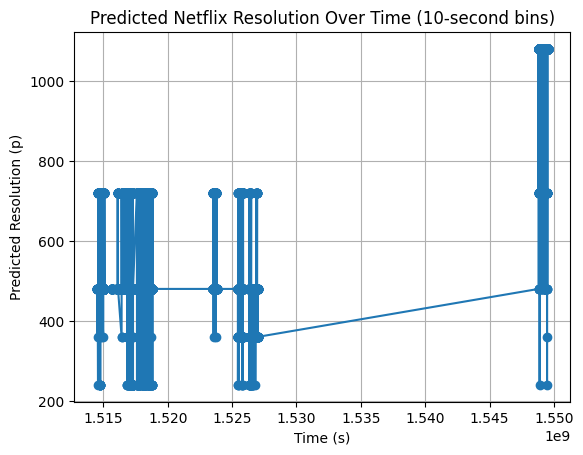

,t_bin_10s,pred_resolution
0,1.514504e+09,480
1,1.514504e+09,480
2,1.514504e+09,480
3,1.514504e+09,480
4,1.514504e+09,480


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_pred_test = best_model.predict(X_test)

test_results = pd.DataFrame(index=X_test.index)
test_results["pred_resolution"] = y_pred_test
test_results["true_resolution"] = y_test.to_numpy()

time_col = None
if "absolute_timestamp" in clean_df.columns:
    time_col = "absolute_timestamp"
elif "bucket_time_start" in clean_df.columns:
    time_col = "bucket_time_start"
else:
    raise ValueError("No obvious time column found (expected 'absolute_timestamp' or 'bucket_time_start').")

test_results["time_s"] = clean_df.loc[X_test.index, time_col].to_numpy()

test_results = test_results.sort_values("time_s")

BIN_SIZE = 10.0
test_results["t_bin_10s"] = (test_results["time_s"] // BIN_SIZE) * BIN_SIZE

bin_resolution = (
    test_results
    .groupby("t_bin_10s")["pred_resolution"]
    .agg(lambda vals: vals.value_counts().idxmax())
    .reset_index()
    .sort_values("t_bin_10s")
)

plt.figure()
plt.plot(bin_resolution["t_bin_10s"], bin_resolution["pred_resolution"], marker="o")
plt.xlabel("Time (s)")
plt.ylabel("Predicted Resolution (p)")
plt.title("Predicted Netflix Resolution Over Time (10-second bins)")
plt.grid(True)
plt.show()

bin_resolution.head()

We treated our held-out test split as an ongoing Netflix session. For each 1-second traffic window in the test set, we used our trained Random Forest model to predict the streaming resolution class (240p, 360p, 480p, 720p, 1080p). We then grouped predictions by 10-second bins and took the most common predicted resolution per bin. Plotting that over time gives us a timeline of inferred video quality. This shows how the adaptive bitrate algorithm behaved during the session (e.g. holding at 480p, then stepping up to 720p, then stabilizing at 1080p). This demonstrates that we can infer QoE from encrypted traffic patterns alone.